<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/balance_RAF_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset,random_split, Subset # Import TensorDataset and Subset here
from torchvision.datasets import ImageFolder # Import ImageFolder here
import matplotlib.pyplot as plt
import pandas as pd
import os
import timm # Import timm library
import numpy as np # Import numpy here
from collections import Counter # Import Counter here
from imblearn.over_sampling import RandomOverSampler # Import RandomOverSampler

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/FER2013/RAF/train'



In [5]:
# Normal test transform — no augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Strong train augmentation for minority samples
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [6]:
# ✅ BalancedAugmentedDataset CLASS
# =====================================================
class BalancedAugmentedDataset(Dataset):
    def __init__(self, image_folder, minority_augment_ratio=2):
        self.dataset = image_folder
        self.targets = np.array(image_folder.targets)

        # class counts
        counter = Counter(self.targets)
        print("Class counts before balance:", counter)

        max_count = max(counter.values())

        self.balanced_indices = []

        # make balanced index list (no direct duplication)
        for cls, count in counter.items():
            cls_idx = np.where(self.targets == cls)[0]

            # exact oversampling factor
            repeat_factor = max_count // count
            extra = max_count - (repeat_factor * count)

            # store original + balanced repeated
            balanced = list(cls_idx) * repeat_factor

            # add extra from original
            if extra > 0:
                balanced += list(np.random.choice(cls_idx, extra, replace=False))

            self.balanced_indices.extend(balanced)

        print("Balanced dataset size:", len(self.balanced_indices))

        # store params
        self.minority_classes = [cls for cls, cnt in counter.items() if cnt < max_count]
        self.minority_augment_ratio = minority_augment_ratio

    def __len__(self):
        return len(self.balanced_indices)

    def __getitem__(self, idx):
        real_idx = self.balanced_indices[idx]
        img, label = self.dataset[real_idx]

        # minority augmentation
        if label in self.minority_classes:
            img = augment_transform(img)
        else:
            img = test_transform(img)

        return img, label

In [7]:
# =====================================================
# 1️⃣ Load raw dataset
# =====================================================
raw_dataset = ImageFolder(root=data_dir, transform=None)
print("Classes:", raw_dataset.classes)
print("Total raw images:", len(raw_dataset))

Classes: ['1', '2', '3', '4', '5', '6', '7']
Total raw images: 15339


In [8]:
# 2️⃣ Create Balanced + Augmented Dataset
# =====================================================
balanced_dataset = BalancedAugmentedDataset(raw_dataset)

Class counts before balance: Counter({np.int64(3): 5957, np.int64(6): 3204, np.int64(4): 2460, np.int64(0): 1619, np.int64(2): 877, np.int64(5): 867, np.int64(1): 355})
Balanced dataset size: 41699


In [9]:
# =====================================================
# 3️⃣ Split Dataset (Train 70%, Val 15%, Test 15%)
# =====================================================
train_size = int(0.7 * len(balanced_dataset))
val_size = int(0.15 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    balanced_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

Train: 29189
Val: 6254
Test: 6256


In [10]:
# =====================================================
# 4️⃣ DataLoaders
# =====================================================
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Loaders Ready!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loaders Ready!
Train batches: 457
Val batches: 98
Test batches: 98


In [11]:
for imgs, labels in train_loader:
    print("Batch image shape:", imgs.shape)
    print("Batch label shape:", labels.shape)
    break


Batch image shape: torch.Size([64, 3, 224, 224])
Batch label shape: torch.Size([64])


In [12]:
import torch.nn.functional as F

In [13]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()


for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Input shape: torch.Size([64, 3, 224, 224])
EfficientNetV2-S Output shape: torch.Size([64, 256, 7, 7])


In [15]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)
        return x

In [16]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [17]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))

In [18]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt Output: torch.Size([64, 256, 28, 28])
SENet+MBConv Output: torch.Size([64, 256, 28, 28])


In [20]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [21]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [22]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([64, 256, 28, 28])


In [23]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [24]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [25]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [26]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([64, 896, 28, 28])


In [27]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [28]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [29]:
class FinalModelWithMobileViT1(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT1, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=(2,2), depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x

In [30]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x

In [31]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break

Final Feature Vector Shape: torch.Size([64, 896])


In [32]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=7, out_ch=448):
        super().__init__()
        self.fusion = MultiBranchFullFusion()
        fused_ch = out_ch * 2
        self.project = nn.Conv2d(fused_ch, 896, kernel_size=1)
        self.mobilevit1 = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(896, 448),
            nn.ReLU(),
            nn.BatchNorm1d(448),
            nn.Dropout(dropout_rate),
            nn.Linear(448, 7)
        )
    def forward(self, x):
        x = self.fusion(x)      # [B, 2*out_ch, H, W]
        x = self.project(x)     # [B, 896, H, W]
        x = self.mobilevit1(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [33]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break

Model Output Shape: torch.Size([64, 7])


In [34]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

In [35]:
def evaluate_model(model, data_loader, criterion, device, class_names=None):
    model.eval()  # Evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # logits (no softmax)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = val_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [36]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
criterion = LabelSmoothingLoss(classes=len(class_names), smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [37]:
def train_model(
        model,
        train_loader, val_loader,
        criterion, optimizer,
        scheduler,              # ✅ new parameter
        num_epochs,
        device,
        checkpoint_path
):
    model.to(device)
    best_val_accuracy = 0
    patience = 5
    patience_counter = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Ensure checkpoint directory exists
    checkpoint_dir = os.path.dirname(checkpoint_path)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for batch_idx, (pixel_batch, label_batch) in enumerate(train_loader):
            pixel_batch, label_batch = pixel_batch.to(device), label_batch.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()

            # Optional gradient clipping (stabilize training)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item() * pixel_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == label_batch).sum().item()
            total += label_batch.size(0)

        train_acc = 100 * train_correct / total
        train_loss /= len(train_loader.dataset)

        # 🔹 Validation phase
        val_loss, val_accuracy = evaluate_model(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            device=device
        )

        # 🔹 Scheduler step (ReduceLROnPlateau expects val_loss)
        scheduler.step(val_loss)

        # 🔹 Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("✅ Best model updated.")
        else:
            patience_counter += 1

        # 🔹 Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

        # 🔹 Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_accuracy)
        # 🔹 Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break



    return history


In [38]:
import os

checkpoint_path = os.path.join(
    os.getcwd(), "checkpoints", "/content/drive/MyDrive/checkpoints/best_model4.pth"
)


In [39]:
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded successfully from checkpoints.")

In [40]:
# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,         # ✅ new param
    num_epochs=50,
    device=device,
    checkpoint_path=checkpoint_path
)

✅ Best model updated.
Epoch [1/50] | Train Loss: 1.1550 | Train Acc: 68.80% | Val Loss: 0.7869 | Val Acc: 87.19%
✅ Best model updated.
Epoch [2/50] | Train Loss: 0.7307 | Train Acc: 91.16% | Val Loss: 0.6305 | Val Acc: 94.88%
✅ Best model updated.
Epoch [3/50] | Train Loss: 0.6269 | Train Acc: 95.87% | Val Loss: 0.5915 | Val Acc: 96.42%
✅ Best model updated.
Epoch [4/50] | Train Loss: 0.5850 | Train Acc: 97.60% | Val Loss: 0.5803 | Val Acc: 96.85%
✅ Best model updated.
Epoch [5/50] | Train Loss: 0.5694 | Train Acc: 97.95% | Val Loss: 0.5573 | Val Acc: 97.91%
✅ Best model updated.
Epoch [6/50] | Train Loss: 0.5532 | Train Acc: 98.57% | Val Loss: 0.5545 | Val Acc: 97.99%
Epoch [7/50] | Train Loss: 0.5484 | Train Acc: 98.76% | Val Loss: 0.5571 | Val Acc: 97.78%
✅ Best model updated.
Epoch [8/50] | Train Loss: 0.5430 | Train Acc: 98.91% | Val Loss: 0.5495 | Val Acc: 98.23%
Epoch [9/50] | Train Loss: 0.5402 | Train Acc: 99.09% | Val Loss: 0.5552 | Val Acc: 98.00%
Epoch [10/50] | Train Loss:

In [41]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

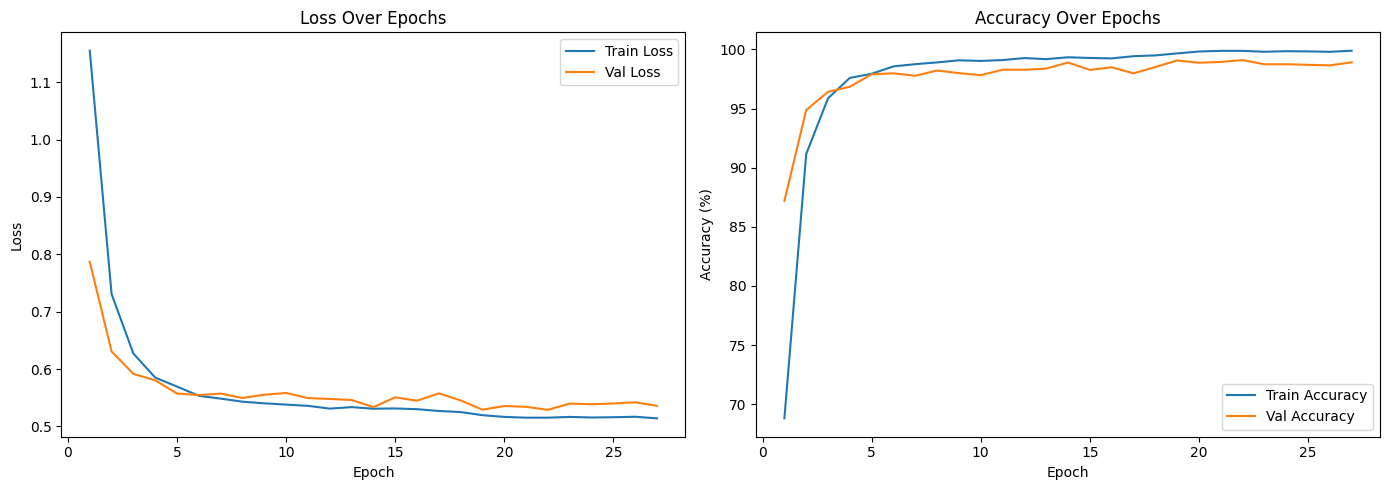

In [42]:
plot_training(history)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define all possible labels (0 to 6 for FER2013)
    all_possible_labels = list(range(len(class_names))) if class_names else sorted(list(set(all_labels + all_preds)))

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_possible_labels, zero_division=0)) # Added labels and zero_division

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # Added labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.99      1.00      0.99       879
     Disgust       1.00      1.00      1.00       891
        Fear       0.99      1.00      0.99       889
       Happy       1.00      1.00      1.00       892
         Sad       0.98      0.97      0.98       931
    Surprise       1.00      1.00      1.00       901
     Neutral       0.97      0.97      0.97       871

    accuracy                           0.99      6254
   macro avg       0.99      0.99      0.99      6254
weighted avg       0.99      0.99      0.99      6254



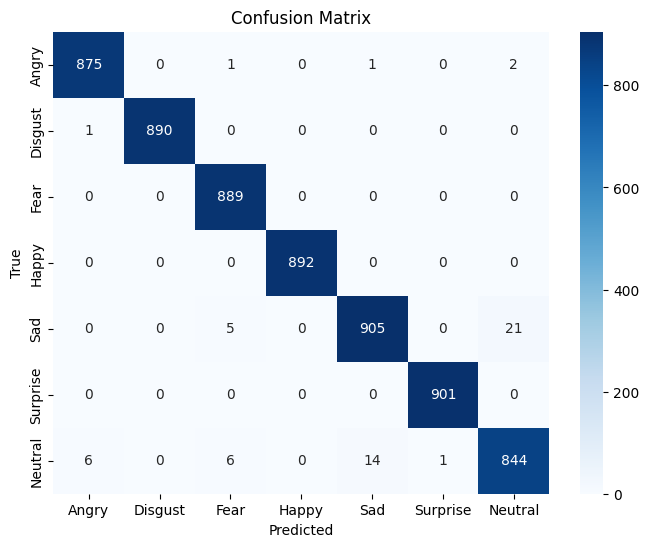

In [44]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
model.load_state_dict(torch.load(checkpoint_path))
evaluate_on_test(model, val_loader, device, class_names)